# Training a transpose convolution layer to output 0s(basically training the filter weights to be 0)

In [32]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.losses import MeanSquaredError

# Define input and target output
input_data = np.ones((1, 2, 2, 1), dtype=np.float32)
target_output = np.zeros((1, 3, 3, 1), dtype=np.float32)

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=2, strides=1, padding='valid', use_bias=True, input_shape=(2, 2, 1))
])

# Compile the model with RMSE loss function
model.compile(optimizer='sgd', loss=MeanSquaredError())

# Train the model
model.fit(input_data, target_output, epochs=1000)

# Evaluate the model
loss = model.evaluate(input_data, target_output)
print("Loss:", loss)

# Get predictions
predictions = model.predict(input_data)
print("Predictions:")
print(predictions)

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 0.1263
Epoch 2/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.1193
Epoch 3/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.1128
Epoch 4/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.1068
Epoch 5/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.1011
Epoch 6/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0959
Epoch 7/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0910
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0865
Epoch 9/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0823
Epoch 10/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.0784
Epoch 11/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0747
Epoch 12/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.0713
Epoch 13/1000
1/1 [======================

In [93]:
np.array([[1,1],[1,1]])

array([[1, 1],
       [1, 1]])

In [9]:
import tensorflow as tf
import numpy as np

# Define the input matrix
input_matrix = np.ones((2, 2))

# Reshape the input matrix to match the expected shape of the Conv2D layer
input_matrix = np.reshape(input_matrix, (1, 2, 2, 1))
print("input_matrix:\n",input_matrix)

# Add padding to the input matrix
input_matrix = tf.pad(input_matrix, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")
print("input_matrix after padding:\n",input_matrix)

# Define the custom filter
custom_filter = np.ones((3, 3, 1, 1))

# Define a function that returns the custom filter
def my_init(shape, dtype=None):
    return custom_filter

# Pass the custom filter to the conv_layer
conv_layer = tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), strides=1, kernel_initializer=my_init, use_bias=False)

# Apply the convolution operation
output = conv_layer(input_matrix)

# Print the output
print(output.numpy()[0, :, :, 0])

input_matrix:
 [[[[1.]
   [1.]]

  [[1.]
   [1.]]]]
input_matrix after padding:
 tf.Tensor(
[[[[0.]
   [0.]
   [0.]
   [0.]]

  [[0.]
   [1.]
   [1.]
   [0.]]

  [[0.]
   [1.]
   [1.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   [0.]]]], shape=(1, 4, 4, 1), dtype=float64)
[[4. 4.]
 [4. 4.]]


In [48]:
def convolute(X, W, strides=(1,1)):
    new_row = (int)((X.shape[0] - W.shape[0])/strides[0] +1)
    new_col = (int)((X.shape[1] - W.shape[1])/strides[1] +1)
    out = np.zeros((new_row, new_col), dtype=float)
    x_last = 0
    y_last = 0
    for x in range(0, X.shape[0]-(W.shape[0] - 1), strides[0]):
        for y in range(0, X.shape[1]-(W.shape[1] - 1), strides[1]):
            amt = 0.0
            for i in range(0, W.shape[0]):
                for j in range(0, W.shape[1]):
                    amt += W[i][j] * X[x+i][y+j]
            out[x_last][y_last] = amt
            y_last += 1
        x_last += 1
        y_last = 0
    return out


#this is the same result as scipy.signal.convolute2d
def convolute_full(X, W, strides=(1, 1)):
    row_num = (X.shape[0] - 1) * strides[0] + W.shape[0]
    col_num = (X.shape[1] - 1) * strides[1] + W.shape[1]
    output = np.zeros([row_num, col_num])
    for i in range(0, X.shape[0]):
        i_prime = i * strides[0] 
        for j in range(0, X.shape[1]):
            j_prime = j * strides[1]
            for k_row in range(W.shape[0]):
                for k_col in range(W.shape[1]):
                    output[i_prime+k_row, j_prime+k_col] += W[k_row, k_col] * X[i, j]
    return output

def convolute_full_backward(X, dZ, dW, strides=(1, 1)):
    for i in range(0, X.shape[0]):
        i_prime = i * strides[0] 
        for j in range(0, X.shape[1]):
            j_prime = j * strides[1]
            for k_row in range(dW.shape[0]):
                for k_col in range(dW.shape[1]):
                    dW[k_row, k_col] += dZ[i_prime+k_row, j_prime+k_col] * X[i, j]
    return dW


def get_errors(predicted, label):
    return label - predicted

def fcn_forward(W, X):
    rotated = np.rot90(np.rot90(W))
    output = convolute_full(X, W)
    return output

def fcn_backward(X, dZ, kernel):
    dw = np.zeros(kernel.shape)
    dw = convolute_full_backward(X, dZ, dw)
    dw = np.rot90(np.rot90(dw))
    dx = convolute(dZ, np.rot90(np.rot90(kernel)))
    np.clip(dx, 10, -10)
    return dx, dw


def forward(weights, X):
    values = []
    values.append(X)
    predicted = fcn_forward(weights[0], X)
    values.append(predicted)
    predicted = fcn_forward(weights[1], predicted)
    values.append(predicted)
    return values

def backward(weights, values, label, learningRate=0.001):
    dz = get_errors(values[-1], label)
    dx, dw = fcn_backward(values[-2], dz, weights[-1])
    weights[-1] = weights[-1] + learningRate*dw
    dz = dx
    dx, dw = fcn_backward(values[-3], dz, weights[-2])
    #new apply dw:
    weights[-2] = weights[-2] + learningRate*dw
    return weights
    

def train_example():
    epoch = int(input("please enter epoch: "))
    inp = np.random.randn(10,10)
    weights = [np.random.randn(3,3), np.random.randn(3,3)]
    label = np.random.randn(14,14)
    for i in range(0, epoch):
        values = forward(weights, inp)
        errors = get_errors(values[-1], label)
        print("error sum at {} is: {}".format(i, np.sum(errors)))
        weights = backward(weights, values, label)

    errors = get_errors(values[-1], label)
    print("error sum at end of training: ", np.sum(errors))
train_example()

error sum at 0 is: 32.12476272474959
error sum at 1 is: 0.5676758058053153
error sum at 2 is: -7.744321338224779
error sum at end of training:  -7.744321338224779


In [47]:
fcn_forward(np.array([[1,2],[3,4]]), np.array([[1,2],[3,4]]))

array([[ 1.,  4.,  4.],
       [ 6., 20., 16.],
       [ 9., 24., 16.]])

In [46]:
fcn_forward(np.array([[1,1],[1,1]]), np.array([[1,1],[1,1]]))

array([[1., 2., 1.],
       [2., 4., 2.],
       [1., 2., 1.]])

In [40]:
import tensorflow as tf
import numpy as np

# Define input and target output
input_data = np.reshape(np.array([[1.0, 2.0],[3.0, 4.0]]), (1, 2, 2, 1)) # np.ones((1, 2, 2, 1), dtype=np.float32)
target_output = np.zeros((1, 3, 3, 1), dtype=np.float32)

# Define the custom filter
custom_filter = np.reshape(np.array([[1.0, 2.0],[3.0, 4.0]]), (2, 2,1, 1)) # np.ones((2, 2, 1, 1))
# Define a function that returns the custom filter
def my_init(shape, dtype=None):
    return custom_filter

# Define the model
layer = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=2, strides=1, padding='valid', use_bias=True,kernel_initializer=my_init, input_shape=(2, 2, 1))
layer(input_data)

<tf.Tensor: shape=(1, 3, 3, 1), dtype=float32, numpy=
array([[[[ 1.],
         [ 4.],
         [ 4.]],

        [[ 6.],
         [20.],
         [16.]],

        [[ 9.],
         [24.],
         [16.]]]], dtype=float32)>

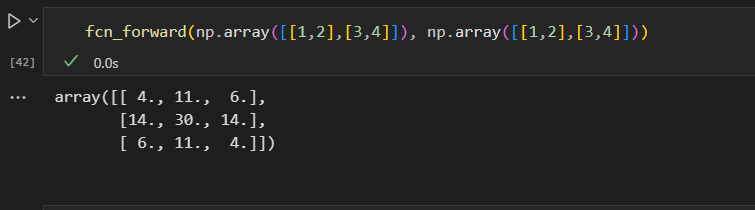 \
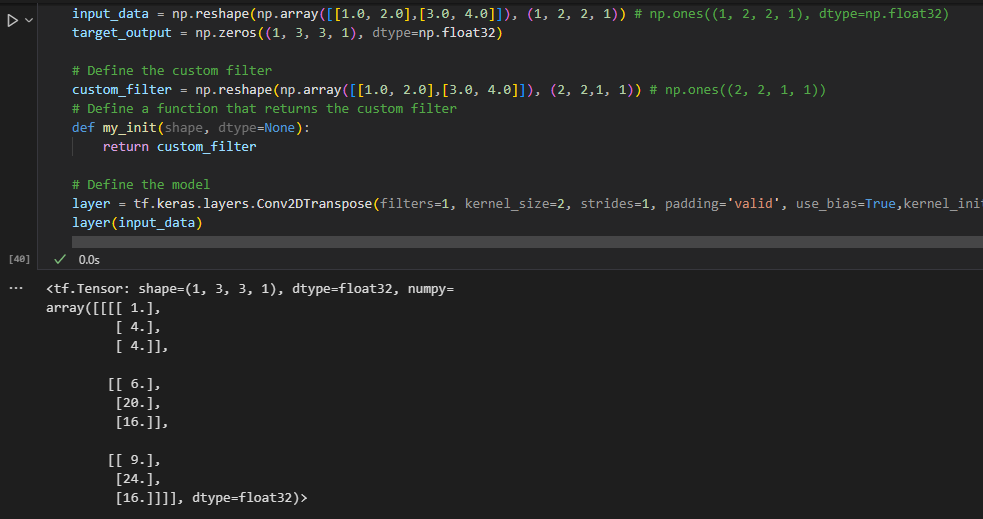 \
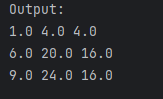